<a href="https://www.kaggle.com/eavannan/heart-disease-ml?scriptVersionId=87754191" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,learning_curve, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import auc,confusion_matrix, roc_curve, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import export_graphviz
import eli5
from eli5.sklearn import PermutationImportance
from subprocess import call
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) #Limiting floats output to 3 decimal points
pd.set_option("display.max_columns", None)

Data contains; 

* age - age in years 
* sex - (1 = male; 0 = female) 
* cp - chest pain type 
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) 
* chol - serum cholestoral in mg/dl 
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg - resting electrocardiographic results 
* thalach - maximum heart rate achieved 
* exang - exercise induced angina (1 = yes; 0 = no) 
* oldpeak - ST depression induced by exercise relative to rest 
* slope - the slope of the peak exercise ST segment 
* ca - number of major vessels (0-3) colored by flourosopy 
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect 
* target - have disease or not (1=yes, 0=no)

In [3]:
data = pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")

In [4]:
data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0    2.300      0   
1   37    1   2       130   250    0        1      187      0    3.500      0   
2   41    0   1       130   204    0        0      172      0    1.400      2   
3   56    1   1       120   236    0        1      178      0    0.800      2   
4   57    0   0       120   354    0        1      163      1    0.600      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

# Basic EDA

In [5]:
data.shape

(303, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
data.describe(include="all")

age     sex      cp  trestbps    chol     fbs  restecg  thalach  \
count 303.000 303.000 303.000   303.000 303.000 303.000  303.000  303.000   
mean   54.366   0.683   0.967   131.624 246.264   0.149    0.528  149.647   
std     9.082   0.466   1.032    17.538  51.831   0.356    0.526   22.905   
min    29.000   0.000   0.000    94.000 126.000   0.000    0.000   71.000   
25%    47.500   0.000   0.000   120.000 211.000   0.000    0.000  133.500   
50%    55.000   1.000   1.000   130.000 240.000   0.000    1.000  153.000   
75%    61.000   1.000   2.000   140.000 274.500   0.000    1.000  166.000   
max    77.000   1.000   3.000   200.000 564.000   1.000    2.000  202.000   

        exang  oldpeak   slope      ca    thal  target  
count 303.000  303.000 303.000 303.000 303.000 303.000  
mean    0.327    1.040   1.399   0.729   2.314   0.545  
std     0.470    1.161   0.616   1.023   0.612   0.499  
min     0.000    0.000   0.000   0.000   0.000   0.000  
25%     0.000    0.000   1.000   0.000   2.000   0.000  
50%     0.000    0.800   1.000   0.000   2.000   1.000  
75%     1.000    1.600   2.000   1.000   3.000   1.000  
max     1.000    6.200   2.000   4.000   3.000   1.000

In [8]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

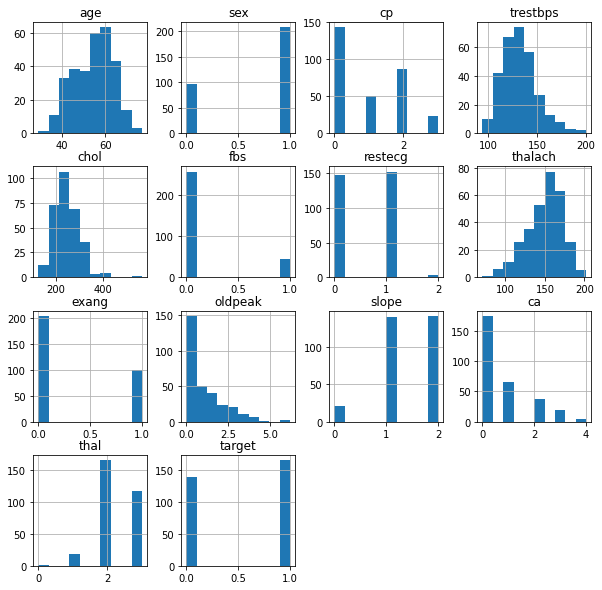

In [9]:
data.hist(figsize=(10,10))
plt.show()

Target data is balanced.

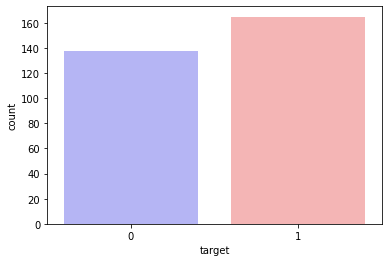

1   0.545
0   0.455
Name: target, dtype: float64

In [10]:
sns.countplot(data.target, palette="bwr")
plt.show()
data.target.value_counts(normalize=True)

In [11]:
continuous_cols = [col for col in data.columns if data[col].nunique()>15]
print(continuous_cols)

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


* correlation among continuous variables are low.

<AxesSubplot:>

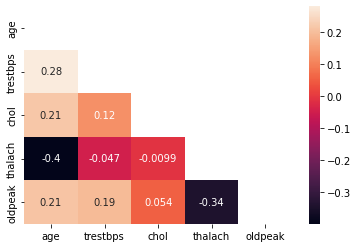

In [12]:
matrix = data[continuous_cols].corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, mask=mask, annot=True)

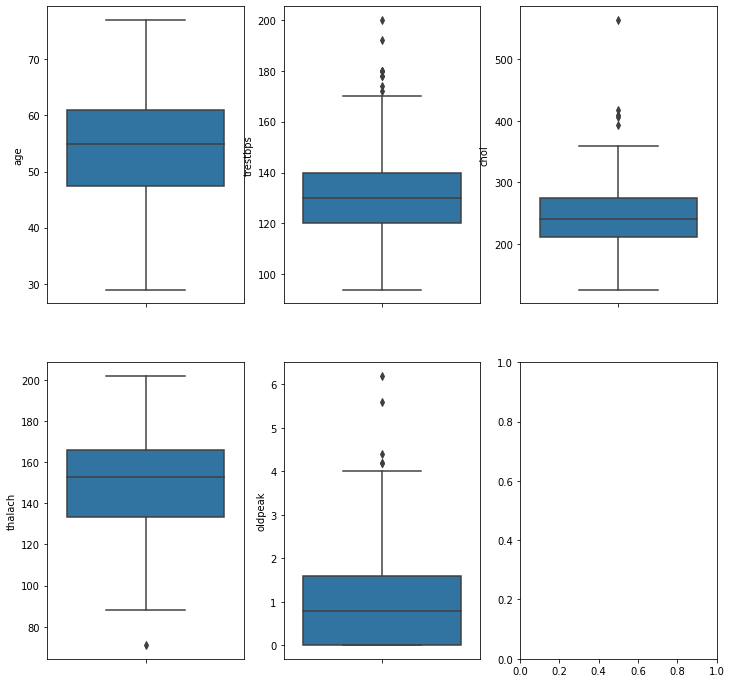

In [13]:
# plot continuous columns
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(12,12))
sns.boxplot(y=data.age, ax=axes[0, 0])
sns.boxplot(y=data.trestbps, ax=axes[0, 1])
sns.boxplot(y=data.chol, ax=axes[0, 2])
sns.boxplot(y=data.thalach,ax=axes[1, 0])
sns.boxplot(y=data.oldpeak,ax=axes[1, 1])
plt.show()

# Handle outliers
* There are outliers in ['thalach', trestbps', 'chol', 'oldpeak']
    * trestbps - resting blood pressure (in mm Hg on admission to the hospital) 
    * chol - serum cholestoral in mg/dl 
    * thalach - maximum heart rate achieved 
    * oldpeak - ST depression induced by exercise relative to rest
* droped 24 outliers

In [14]:
outliers = []
def percentile_outliers(col):
    q1 = np.percentile(col, 1)
    q3 = np.percentile(col, 99)
    IQR = q3-q1
    for i in col:
        if i > q3 or i < q1:
            outliers.append(i)
    print("Outliers:",outliers)


In [15]:
outliers = []
chol_out = percentile_outliers(data['chol'].sort_values())
print(chol_out)
data.drop((data[data.chol > 400].index) | (data[data.chol < 141].index), inplace=True)

Outliers: [126, 131, 141, 407, 409, 417, 564]
None


In [16]:
outliers = []
thalach_out = percentile_outliers(data['thalach'].sort_values())
print(thalach_out)
data.drop((data[data.thalach > 191].index) | (data[data.thalach < 96].index), inplace=True)

Outliers: [71, 88, 90, 194, 195, 202]
None


In [17]:
outliers = []
trestbps_out = percentile_outliers(data['trestbps'].sort_values())
print(trestbps_out)
data.drop((data[data.trestbps > 191].index) | (data[data.trestbps < 95].index), inplace=True)

Outliers: [94, 94, 200]
None


In [18]:
outliers = []
age_out = percentile_outliers(data['age'].sort_values())
print(age_out)
data.drop((data[data.age > 73].index) | (data[data.age < 35].index), inplace=True)

Outliers: [34, 74, 76, 77]
None


In [19]:
outliers = []
oldpeak_out = percentile_outliers(data['oldpeak'].sort_values())
print(oldpeak_out)
data.drop(data[data.oldpeak > 4.3].index, inplace=True)

Outliers: [4.4, 5.6, 6.2]
None


In [20]:
data.shape # original shape was (303, 14)

(279, 14)

In [21]:
data.loc[:, continuous_cols + ["target"]].groupby("target").mean()

age  trestbps    chol  thalach  oldpeak
target                                           
0      56.296   133.144 249.280  140.376    1.490
1      52.558   129.844 241.123  157.955    0.590

# ANOVA Test (Numerical vs Categorical)
* thalach and oldpeak are highly corelated with target(heart disease).
    * thalach - maximum heart rate achieved 
    * oldpeak - ST depression induced by exercise relative to rest 
  

In [22]:
########################################################
# f_oneway() function takes the group data as input and 
# returns F-statistic and P-value

# Running the one-way anova test between "target" and other continuous independent variables
# Assumption(H0) is that "target" and an independent variable are NOT correlated
 
def anova_test(feature, target):
    CategoryGroupLists=data.groupby(feature)[target].apply(list)
    # Performing the ANOVA test
    # We accept the Assumption(H0) only when P-Value &gt; 0.05
    AnovaResults = f_oneway(*CategoryGroupLists)
    return round(AnovaResults[1],4)

continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
print("Age and target: P value is {}".format(anova_test("age", "target")))
print("trestbps and target: P value is {}".format(anova_test("trestbps", "target")))
print("chol and target: P value is {}".format(anova_test("chol", "target")))
print("thalach and target: P value is {}".format(anova_test("thalach", "target")))
print("oldpeak and target: P value is {}".format(anova_test("oldpeak", "target")))

Age and target: P value is 0.2003
trestbps and target: P value is 0.7211
chol and target: P value is 0.0812
thalach and target: P value is 0.0375
oldpeak and target: P value is 0.0


In [23]:
# fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(14,8))
# sns.boxplot(ax=axes[0, 0], data=data, y='age', x='target')
# sns.boxplot(ax=axes[0, 1], data=data, y='trestbps', x='target')
# sns.boxplot(ax=axes[0, 2], data=data, y='chol', x='target')
# sns.boxplot(ax=axes[1, 0], data=data, y='thalach', x='target')
# sns.boxplot(ax=axes[1, 1], data=data, y='oldpeak', x='target')
# plt.show()

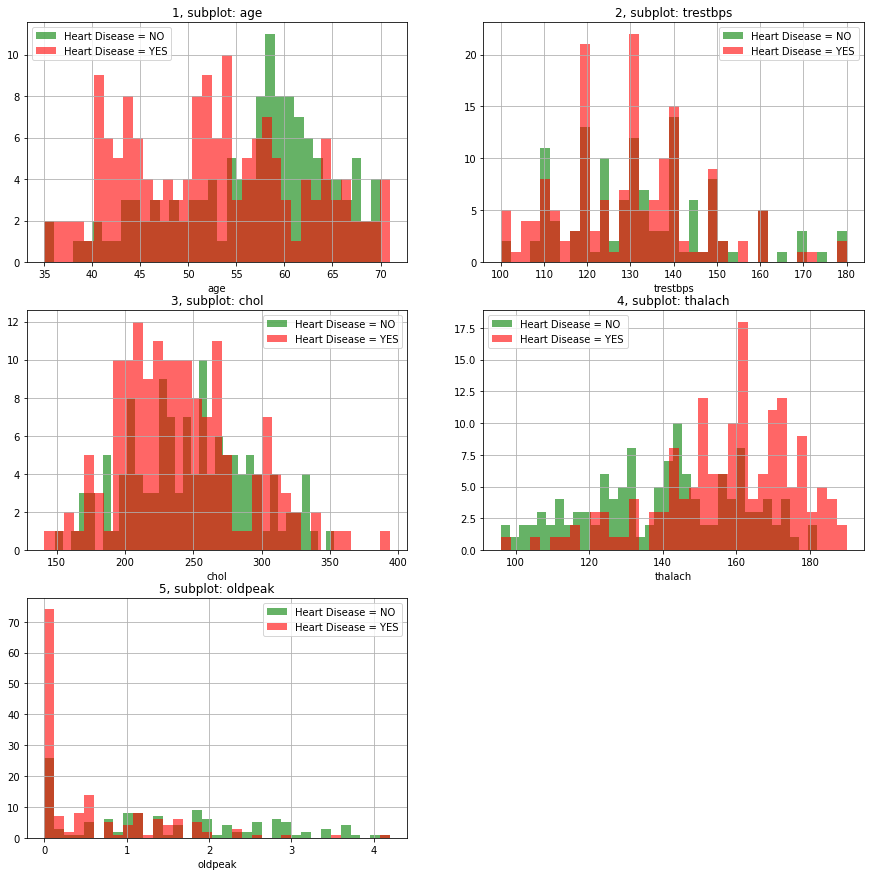

In [24]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    data[data["target"] == 0][col].hist(bins=35, color='green', label='Heart Disease = NO', alpha=0.6)
    data[data["target"] == 1][col].hist(bins=35, color='red', label='Heart Disease = YES', alpha=0.6)
    plt.legend()
    plt.title('{}, subplot: {}'.format(i, col))
    plt.xlabel(col)

# Chi-squred test (categorical vs categorical)
##### ['sex', 'ca', 'cp', 'exang', 'restecg', 'sex', 'slope', 'thal'] are highly related to the target (heart disease).

* ca - number of major vessels (0-3) colored by flourosopy 
* cp - chest pain type 
* exang - exercise induced angina (1 = yes; 0 = no) 
* restecg - resting electrocardiographic results 
* slope - the slope of the peak exercise ST segment 
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect 

##### fbs does not so important to heart disease diagonosis.
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 

In [25]:
cat_cols = [col for col in data.columns if data[col].nunique()<=15] #categorical columns
print(cat_cols)
cat_cols.remove("target") # dropped the target column
print(cat_cols)

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [26]:
# for col in cat_cols:
#     result = data[col].value_counts(normalize=True)
#     print(col)
#     print(result)

In [27]:
def chitest(indepentVal, dependentVal):
    # Cross tabulation between two variables
    Crosstable = pd.crosstab(index=indepentVal,columns=dependentVal)

    # Performing Chi-sq test
    ChiSqResult = chi2_contingency(Crosstable) #chi2_contingency module from scipy.stats

    # P-Value is the Probability of H0 being True
    # H0 is that two variable are not related
    # If P-Value&gt;0.05 then only we Accept the assumption(H0)
    return round(ChiSqResult[1],4)

In [28]:
chitest_dic = {}
for i in cat_cols:
    chitest_dic[i] = chitest(data[i], data['target'])
chitest_dic

{'sex': 0.0,
 'cp': 0.0,
 'fbs': 0.5876,
 'restecg': 0.0041,
 'exang': 0.0,
 'slope': 0.0,
 'ca': 0.0,
 'thal': 0.0}

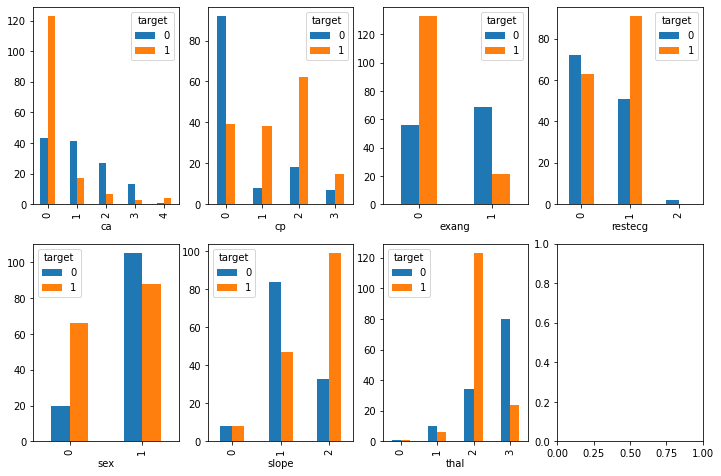

In [29]:
# plot continuous columns
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(12,8))
pd.crosstab(data.ca, data.target).plot(kind="bar",ax=axes[0, 0])
pd.crosstab(data.cp, data.target).plot(kind="bar",ax=axes[0, 1])
pd.crosstab(data.exang, data.target).plot(kind="bar",ax=axes[0, 2])
pd.crosstab(data.restecg, data.target).plot(kind="bar",ax=axes[0, 3])
pd.crosstab(data.sex, data.target).plot(kind="bar",ax=axes[1, 0])
pd.crosstab(data.slope, data.target).plot(kind="bar",ax=axes[1,1])
pd.crosstab(data.thal, data.target).plot(kind="bar",ax=axes[1, 2])
plt.show()

* Male has twice more data than female. If we have more female patients, the correlation bettwen sex and target might change.

# Build Model

### Preprocessing & Spliting data

In [30]:
ohe_col = []
for col in data.columns:
    if data[col].nunique() < 15:
        ohe_col.append(col)
        print("{}{}".format(col, data[col].unique()))
ohe_col.remove("target")

sex[1 0]
cp[3 2 1 0]
fbs[1 0]
restecg[0 1 2]
exang[0 1]
slope[0 2 1]
ca[0 2 1 3 4]
thal[1 2 3 0]
target[1 0]


In [31]:
X = data.drop("target", axis=1)
y = data.target

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),ohe_col), remainder='passthrough')
sc = StandardScaler()

print(X_train.shape, X_test.shape)

(223, 13) (56, 13)


### Output functions

In [33]:
accuracies = {}
def evaluation(model_name, model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_train_preds),
    acc_test = accuracy_score(y_test, y_test_preds),
    accuracies[model_name] = [acc_train,acc_test]
    return accuracies



In [34]:
def print_score(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    train_t = pd.DataFrame(classification_report(y_train,y_train_preds, output_dict=True))
    test_t = pd.DataFrame(classification_report(y_test,y_test_preds, output_dict=True))
    return pd.concat([train_t, test_t], keys=['Trai_score', 'Test_score']) 
    

### Decision Tree

In [35]:
model = DecisionTreeClassifier(random_state=42) 
pipe = make_pipeline(ct, model)
pipe.get_params().keys()
params = {'decisiontreeclassifier__splitter': ["best", "random"],
          'decisiontreeclassifier__max_depth': np.arange(1,10,1),
          'decisiontreeclassifier__min_samples_leaf': np.arange(1,5,1),
          'decisiontreeclassifier__min_samples_split': np.arange(2,5,1)
         }
cv_dt = GridSearchCV(pipe, param_grid=params, scoring="accuracy", n_jobs=-1)
cv_dt.fit(X_train, y_train)
preds_dt = cv_dt.predict(X_test)
print(cv_dt.best_params_, cv_dt.best_score_)
print(cv_dt.score(X_test, y_test))

#print_score(cv_dt, X_train, y_train, X_test, y_test)



{'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__splitter': 'random'} 0.8114141414141415
0.8392857142857143


In [36]:
from sklearn import tree
import graphviz
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter="random")
clf.fit(X_train, y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns, 
                                filled=True, rounded=True,  
                                special_characters=True)  

graph = graphviz.Source(dot_data) 
graph.render("Heart Disease") 


# from sklearn import tree
# clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter="random")
# clf.fit(X_train, y_train)
# plt.figure(figsize=(15,15))
# tree.plot_tree(clf)
# plt.show()

'Heart Disease.pdf'

### Random Forest

In [37]:
model = RandomForestClassifier(random_state=42) 
pipe = make_pipeline(ct, model)
pipe.get_params().keys()
params = {'randomforestclassifier__n_estimators': np.arange(10,50,10),
         'randomforestclassifier__max_depth': np.arange(1,8,2)
         }
cv_rf = GridSearchCV(pipe, param_grid=params, scoring="accuracy", n_jobs=-1, cv=5)
cv_rf.fit(X_train, y_train)
preds_rf = cv_rf.predict(X_test)
print(cv_rf.best_params_, cv_rf.best_score_)
print(cv_rf.score(X_test, y_test))
#print_score(cv_rf, X_train, y_train, X_test, y_test)


{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 40} 0.8158585858585858
0.8571428571428571


### XGBClassifier

In [38]:

model = XGBClassifier(random_state=42,use_label_encoder=False, eval_metric="logloss") 
pipe = make_pipeline(ct, model)
#pipe.get_params().keys()
params = {"xgbclassifier__n_estimators": np.arange(10,30,10), 
          "xgbclassifier__learning_rate": np.arange(0.01,0.02,0.002)
          #"xgbclassifier__max_depth": np.arange(1,3,1)
         }
cv_xg = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=3)
cv_xg.fit(X_train, y_train)
preds_xg = cv_xg.predict(X_test)
print(cv_xg.score(X_test, y_test))
print(cv_xg.best_params_, cv_xg.best_score_)

#print_score(cv_xg, X_train, y_train, X_test, y_test)

0.8928571428571429
{'xgbclassifier__learning_rate': 0.012, 'xgbclassifier__n_estimators': 20} 0.7799999999999999


### Logistic Regression

In [39]:
# col_to_scale = ["age", "trestbps", "chol", "thalach", "oldpeak"]
# X_train[col_to_scale] = sc.fit_transform(X_train[col_to_scale])
# X_test[col_to_scale] = sc.transform(X_test[col_to_scale])


model = LogisticRegression(solver='liblinear', random_state=42) 
pipe = make_pipeline(ct, sc, model)
#pipe.get_params().keys()
params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': np.arange(0.1,1,0.1)}
cv_lr = GridSearchCV(pipe, param_grid=params, scoring="accuracy", n_jobs=-1)
cv_lr.fit(X_train, y_train)
preds_lr = cv_lr.predict(X_test)
print(cv_lr.best_params_, cv_lr.best_score_)
print(cv_lr.score(X_test, y_test))
#print_score(cv_lr, X_train, y_train, X_test, y_test)

{'logisticregression__C': 0.2, 'logisticregression__penalty': 'l1'} 0.8250505050505051
0.8571428571428571


### SVM

In [40]:
model = SVC(random_state=42) 
pipe = make_pipeline(ct, sc, model)
pipe.get_params().keys()
params = {'svc__kernel': ['linear', 'rbf'], 'svc__C': np.arange(0.5,1,0.1), 'svc__gamma': np.arange(0.01,0.05,0.01)}
cv_svm = GridSearchCV(pipe, param_grid=params, scoring="accuracy", n_jobs=-1)
cv_svm.fit(X_train, y_train)
preds_svm = cv_svm.predict(X_test)
print(cv_svm.best_params_, cv_svm.best_score_)
print(cv_svm.score(X_test, y_test))

{'svc__C': 0.5, 'svc__gamma': 0.04, 'svc__kernel': 'rbf'} 0.8250505050505051
0.8571428571428571


In [41]:
#print_score(cv_svm, X_train, y_train, X_test, y_test)

### KNeighbors

In [42]:
model = KNeighborsClassifier() 
pipe = make_pipeline(ct, sc, model)
pipe.get_params().keys()
params = {'kneighborsclassifier__n_neighbors': np.arange(5,10,1), "kneighborsclassifier__weights": ['uniform', 'distance']}
cv_knn = GridSearchCV(pipe, param_grid=params, scoring="accuracy", n_jobs=-1)
cv_knn.fit(X_train, y_train)
preds_knn = cv_knn.predict(X_test)
print(cv_knn.best_params_, cv_knn.best_score_)
print(cv_knn.score(X_test, y_test))
#print_score(cv_knn, X_train, y_train, X_test, y_test)

{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__weights': 'distance'} 0.8292929292929292
0.8928571428571429


In [43]:
# ## Visulise a trend in accuricies when n_neighbors changes.
# train_accs = []
# test_accs = []
# for i in np.arange(5,35,5):
#     model = KNeighborsClassifier(n_neighbors=i)
#     model.fit(X_train, y_train)
#     y_train_preds = model.predict(X_train)
#     y_test_preds = model.predict(X_test)
#     train_accs.append(accuracy_score(y_train, y_train_preds))
#     test_accs.append(accuracy_score(y_test, y_test_preds))

# plt.figure(figsize=(10,10))
# plt.plot(np.arange(5,35,5), train_accs, label='Train')
# plt.plot(np.arange(5,35,5), test_accs, label='Test')
# plt.xlabel("No of neighbors")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

### Model Comparison

In [44]:
evaluation("Logistic Model", cv_lr, X_train, y_train, X_test, y_test)
evaluation("SVM Model", cv_svm, X_train, y_train, X_test, y_test)
evaluation("Knn Model", cv_knn, X_train, y_train, X_test, y_test)
evaluation("Decision Tree Model", cv_dt, X_train, y_train, X_test, y_test)
evaluation("Random Forest Model", cv_rf, X_train, y_train, X_test, y_test)
evaluation("XGBoost Model", cv_xg, X_train, y_train, X_test, y_test)

accuracies = pd.DataFrame.from_dict(accuracies, orient="index", columns=['Train_acc', 'Test_acc'])
accuracies

Train_acc               Test_acc
Logistic Model        (0.852017937219731,)  (0.8571428571428571,)
SVM Model            (0.9192825112107623,)  (0.8571428571428571,)
Knn Model                           (1.0,)  (0.8928571428571429,)
Decision Tree Model  (0.9282511210762332,)  (0.8392857142857143,)
Random Forest Model  (0.9282511210762332,)  (0.8571428571428571,)
XGBoost Model        (0.9147982062780269,)  (0.8928571428571429,)

In [45]:
#### AUC comparison
# classifiers = {
#     "SVM": SVC(C=0.9, gamma=0.02, kernel='rbf'), 
#     "Random Forest": RandomForestClassifier(
#         max_depth=5, n_estimators=100, max_features=1
#     ),
# }

# # prepare plots
# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(fpr, tpr)
#     display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
#     display.plot()
#     plt.show()




# Visualise Random Forest

In [46]:
for col in cat_cols:
    data[col] = data[col].astype("object")
    
X = data.drop("target", axis=1)
X = pd.get_dummies(X, drop_first=True)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(223, 22) (56, 22)


In [47]:
model = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
model.fit(X_train, y_train)
# Extract single tree
estimator = model.estimators_[5]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
#type(y_train_str.values)
target_names = y_train_str.values



In [48]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Model Insights
### 1) Permutation importance
Interpretation: The first number in each row shows how much model performance decreased with a random shuffling. There is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.
Ref: https://www.kaggle.com/dansbecker/permutation-importance

Age, restecg, thalach: these columns have negative weights for permutation importances, which means the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. It is understandable because our datasets are quite small, so there is more room for luck/chance.



In [49]:
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())
eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names = X_test.columns.tolist())

feature  weight   std
0     oldpeak   0.039 0.021
1      thal_2   0.025 0.021
2     slope_1   0.025 0.009
3        cp_1   0.021 0.007
4        ca_1   0.018 0.000
5        ca_2   0.011 0.009
6     exang_1   0.011 0.009
7     slope_2   0.004 0.007
8      thal_1   0.000 0.000
9        ca_4   0.000 0.000
10  restecg_2   0.000 0.000
11      fbs_1   0.000 0.000
12       cp_2   0.000 0.000
13       ca_3  -0.000 0.011
14       cp_3  -0.000 0.011
15     thal_3  -0.004 0.029
16        age  -0.004 0.007
17      sex_1  -0.004 0.007
18       chol  -0.007 0.009
19  restecg_1  -0.014 0.013
20   trestbps  -0.014 0.007
21    thalach  -0.029 0.018

### 2) Partial plots
Partial dependence plots show how a feature affects predictions.
* The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence



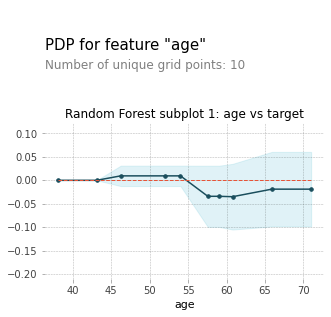

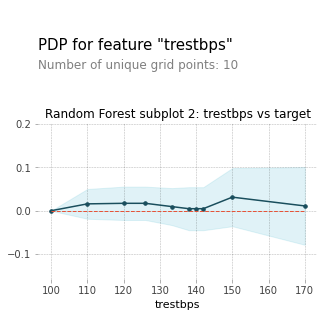

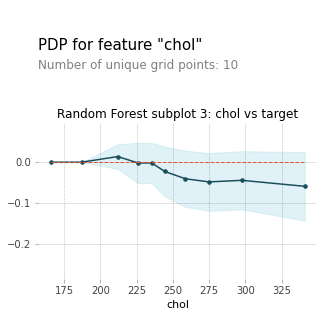

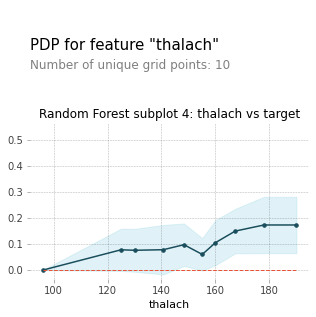

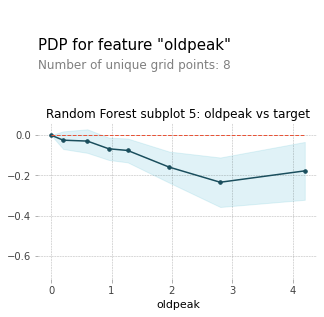

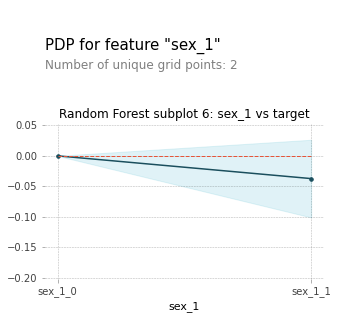

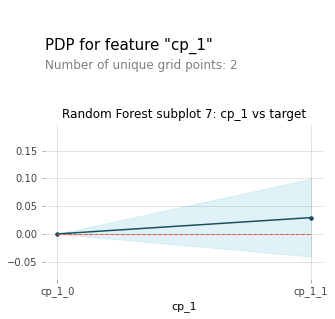

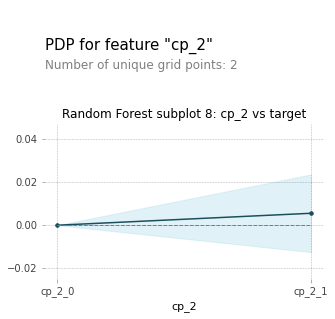

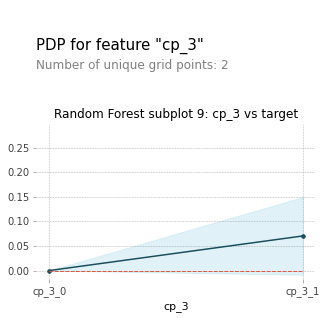

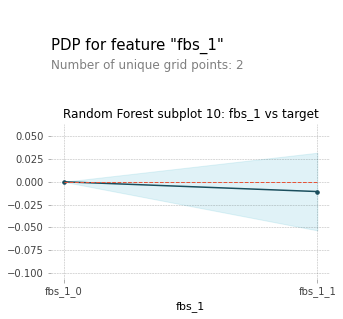

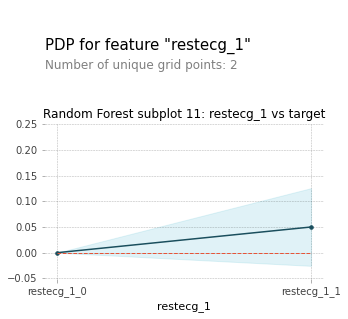

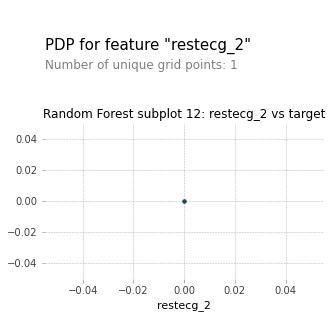

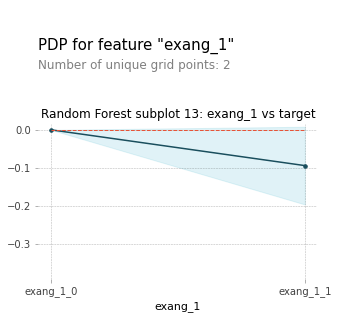

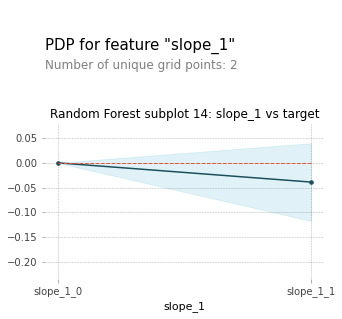

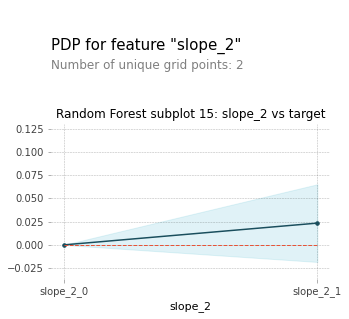

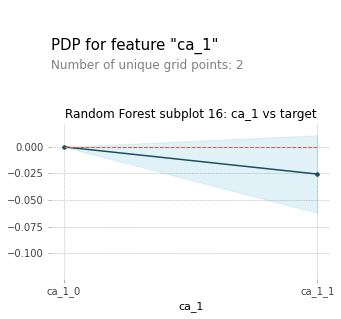

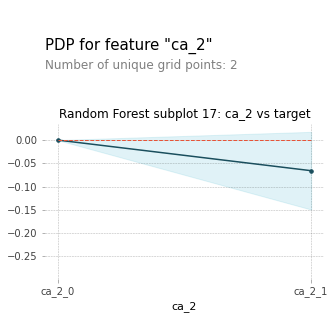

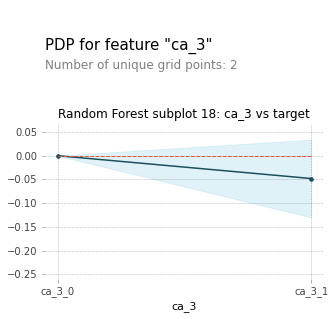

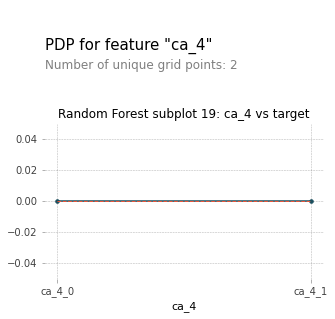

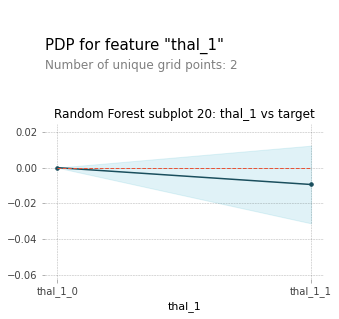

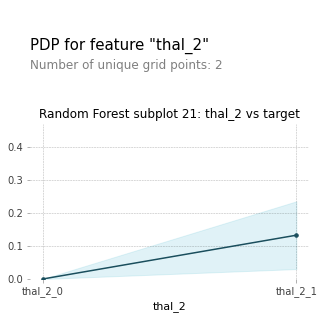

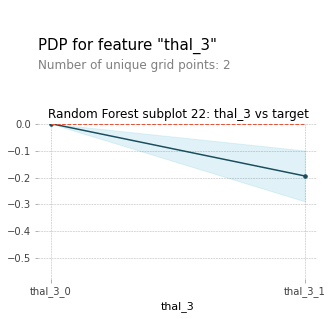

In [50]:
# decision_tree_model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split = 2)
# decision_tree_model.fit(X_train, y_train)

from pdpbox import pdp, info_plots #for partial plots
cols = X.columns.tolist()


for i, col in enumerate(cols, 1):
    pdp_dist_rf = pdp.pdp_isolate(model=model, dataset=X_test, model_features=cols, feature=col)
    #pdp_dist_dt = pdp.pdp_isolate(model=decision_tree_model, dataset=X_test, model_features=cols, feature=col)
    pdp.pdp_plot(pdp_dist_rf, col, figsize=(5,5))
    plt.title('Random Forest subplot {}: {} vs target'.format(i, col))
    #pdp.pdp_plot(pdp_dist_dt, col, figsize=(5,5))
    #plt.title('Decision Tree subplot {}: {} vs target'.format(i, col))
    plt.show()

### 3) SHAP

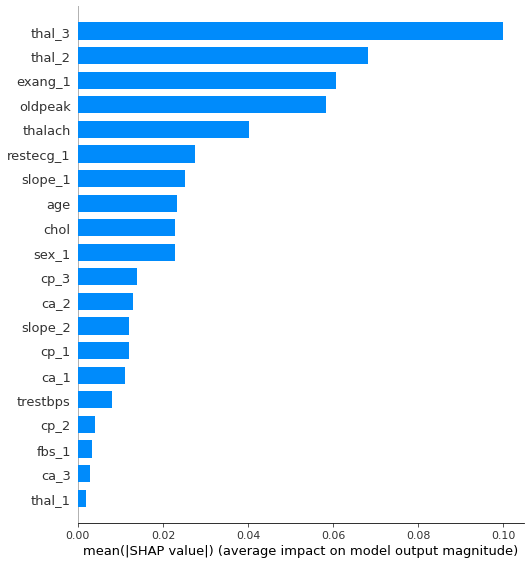

In [51]:
import shap #for SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

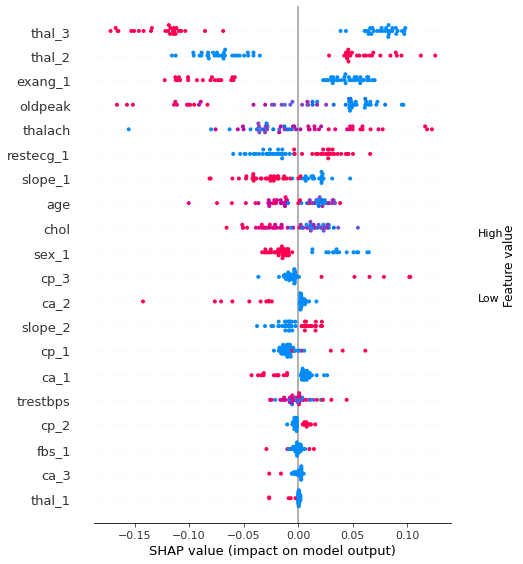

In [52]:
shap.summary_plot(shap_values[1], X_test)

In [53]:
def heart_disease_risk_factors(model, patient):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

# ROC curve

In [54]:
# Evaluate model
y_pred = model.predict(X_test)

# check performance with confusion matrix
cm = confusion_matrix(y_test, y_pred)
total = np.sum(cm)
sensitivity = cm[0,0]/(cm[0,0] + cm[1,0])
specificity = cm[1,1]/(cm[0,1] + cm[1,1])
print('Sensitivity : {:.2f}, Specificity: {:.2f}'.format(sensitivity,specificity))



Sensitivity : 0.77, Specificity: 0.88


Area under the curve : 0.8936


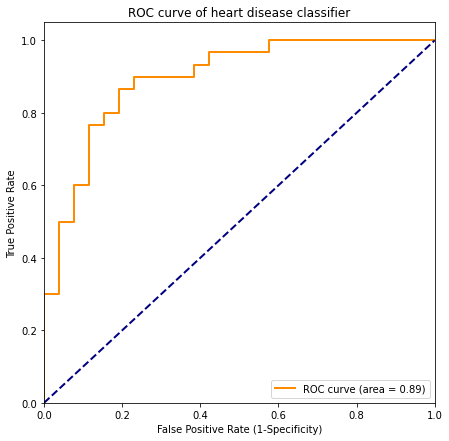

In [55]:
# check performance with AUC and ROC curve
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

auc_score = auc(fpr, tpr)
print('Area under the curve : {:.4f}'.format(auc_score))

# plot Receiver operating characteristic curve
plt.figure(figsize=(7,7))
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of heart disease classifier")
plt.legend(loc="lower right")
#plt.grid(True)
plt.show()

# Feature selection

* "exang": keep
* "thal": keep
* "slope": keep
* "chol": keep
* "oldpeak": keep
* "cp": keep
* "restecg": keep
* "thalach": keep
* "ca": keep

* "sex": drop, this feature does have a certain level of importance to the target, but the sex column itself is highly unbalanced, so I am not sure how reliable this column is.
* "fbs": drop
* "age": drop, the dip bettwen 55 and 60 does not make much sense. Why would 60 years old has lower probability of heart desease than 55 years old. We know age had an importance close to 0 in the Permutation importance test. age column seems safe to drop.
* "trestbps": drop

In [56]:
for col in cat_cols:
    data[col] = data[col].astype("object")
drop_cols = ["sex", "fbs", "age", "trestbps", "target"]
X = data.drop(drop_cols, axis=1)
y = data.target
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5) 
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print_score(model, X_train, y_train, X_test, y_test)



0.8392857142857143


0       1  accuracy  macro avg  weighted avg
Trai_score precision  0.901   0.871     0.883      0.886         0.884
           recall     0.828   0.927     0.883      0.878         0.883
           f1-score   0.863   0.898     0.883      0.881         0.883
           support   99.000 124.000     0.883    223.000       223.000
Test_score precision  0.793   0.889     0.839      0.841         0.844
           recall     0.885   0.800     0.839      0.842         0.839
           f1-score   0.836   0.842     0.839      0.839         0.839
           support   26.000  30.000     0.839     56.000        56.000

In [57]:
# Visulise Tree
estimator = model.estimators_[5]
feature_names = [i for i in X.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
#type(y_train_str.values)
target_names = y_train_str.values



from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

### Reference
I've read some great notebooks in Kaggle and would like to express my gratitude to the creators of notebooks below. 
* [Predicting heart disease using machine learning](https://www.kaggle.com/faressayah/predicting-heart-disease-using-machine-learning) by FARES SAYAH
* [What Causes Heart Disease? Explaining the Model](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model/notebook)
